In [1]:
# 8. Complete OCR Pipeline

Extracted Text:
. - » +. ~ . . as . - oe
ww, mY .- * . * aan . ;
ah aie i oe
a & =z Lf
an
was '
-
ww. UG. Ve
aR 4 Pig pee tat fy
fe =. j c *
~~ ; co, ne b ] “0 ord arg howls
e Choose a topological ordernng of the nodes (i.e. an ordering where any node i
comes after all of its parents),
e Let v, be the set of nodes that are not parents of 1, Le. 7,04, — @, but they
appear in the topological ordering before 1.
e Then the graph implies the conditional independence x, LL x,,[X-,.
| Note that there may be many topological orderings for a graph. With the above
procedure, different conditional independences can be found using different topolog-
ical orderings. Now. we discuss a simpler and more general procedure for testing
conditional independence which does not depend on any particular topological order-
ing.
2.2 Graph Separation and Conditional Independence ~
We now introduce the idea of graph separation: testing conditional independence
properties by looking for particular kinds of paths 

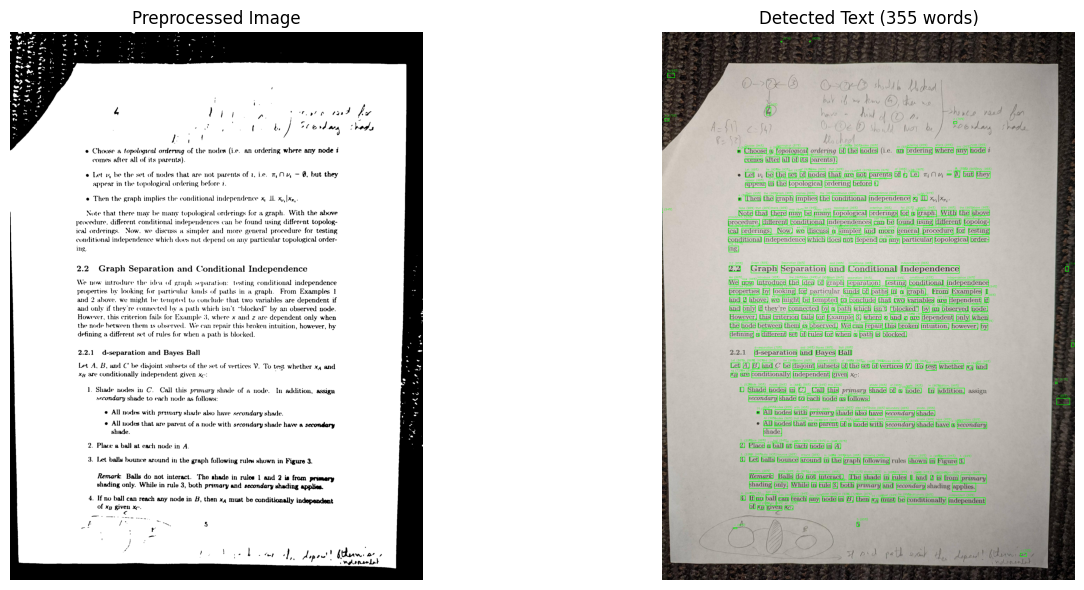


Detected Words:
.                              | Confidence:  67% | BBox: (680, 52, 6, 6)
.                              | Confidence:  85% | BBox: (844, 51, 5, 6)
a                              | Confidence:  69% | BBox: (30, 235, 42, 26)
4                              | Confidence:  96% | BBox: (596, 430, 27, 46)
fe                             | Confidence:  75% | BBox: (15, 493, 25, 17)
c                              | Confidence:  76% | BBox: (1667, 512, 20, 13)
e                              | Confidence:  66% | BBox: (432, 676, 17, 16)
Choose                         | Confidence:  94% | BBox: (472, 665, 126, 31)
a                              | Confidence:  96% | BBox: (616, 675, 19, 19)
topological                    | Confidence:  87% | BBox: (655, 664, 179, 39)
of                             | Confidence:  96% | BBox: (1015, 664, 34, 31)
the                            | Confidence:  95% | BBox: (1065, 664, 53, 30)
nodes                          | Confidence:  96% | BBox: (113

In [4]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class TesseractOCR: 
    """
    Complete Tesseract OCR pipeline with preprocessing
    """
    
    def __init__(self, psm=6, lang='eng'):
        self.psm = psm
        self.lang = lang
        self.config = f'--psm {psm} --oem 3'
    
    def preprocess(self, image):
        """
        Preprocess image for better OCR
        """
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        # Denoise
        denoised = cv2.bilateralFilter(gray, 9, 75, 75)
        
        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)
        
        # Binarize
        _, binary = cv2.threshold(enhanced, 0, 255,
                                  cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Remove small noise
        kernel = np. ones((2, 2), np.uint8)
        clean = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        return clean
    
    def extract_text(self, image_path, preprocess=True):
        """
        Extract text from image
        """
        # Load image
        img = cv2.imread(image_path)
        
        if preprocess:
            processed = self.preprocess(img)
        else:
            processed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # OCR
        text = pytesseract.image_to_string(processed, 
                                           lang=self.lang,
                                           config=self.config)
        
        return text, processed
    
    def extract_with_boxes(self, image_path, preprocess=True, conf_threshold=60):
        """
        Extract text with bounding boxes
        """
        # Load image
        img = cv2.imread(image_path)
        display_img = img.copy()
        
        if preprocess:
            processed = self.preprocess(img)
        else:
            processed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Get data
        data = pytesseract.image_to_data(processed, 
                                         lang=self.lang,
                                         config=self.config,
                                         output_type=pytesseract.Output. DICT)
        
        # Extract words with high confidence
        results = []
        n_boxes = len(data['text'])
        
        for i in range(n_boxes):
            conf = int(data['conf'][i])
            text = data['text'][i]. strip()
            
            if conf > conf_threshold and text:
                x = data['left'][i]
                y = data['top'][i]
                w = data['width'][i]
                h = data['height'][i]
                
                results.append({
                    'text': text,
                    'confidence': conf,
                    'bbox': (x, y, w, h)
                })
                
                # Draw on image
                cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                label = f"{text} ({conf}%)"
                cv2.putText(display_img, label, (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        return results, display_img, processed
    
    def save_results(self, results, output_path='ocr_results.txt'):
        """
        Save OCR results to file
        """
        with open(output_path, 'w', encoding='utf-8') as f:
            for item in results:
                f.write(f"{item['text']}\t{item['confidence']}%\n")
        
        print(f"Results saved to {output_path}")

# =============================================
# USAGE EXAMPLE
# =============================================

# Initialize OCR
ocr = TesseractOCR(psm=6, lang='eng')

# Simple text extraction
text, processed = ocr.extract_text('/Users/karansingh/ocr-learning/pytesseract/vlrYO.jpg', preprocess=True)
print("Extracted Text:")
print(text)

# Extract with bounding boxes
results, annotated, processed = ocr.extract_with_boxes('/Users/karansingh/ocr-learning/pytesseract/vlrYO.jpg', 
                                                        preprocess=True,
                                                        conf_threshold=60)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(processed, cmap='gray')
axes[0].set_title('Preprocessed Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Detected Text ({len(results)} words)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print detected words
print("\nDetected Words:")
print("="*60)
for item in results:
    print(f"{item['text']:30s} | Confidence: {item['confidence']:3d}% | BBox: {item['bbox']}")

# Save results
ocr.save_results(results)

# Project 1: Receipt Scanner

In [7]:
import cv2
import pytesseract
import re

class ReceiptScanner: 
    """
    Extract structured data from receipts
    """
    
    def __init__(self):
        self.ocr = TesseractOCR(psm=6, lang='eng')
    
    def extract_amount(self, text):
        """
        Extract total amount from receipt text
        """
        # Pattern: $XX.XX or XX.XX
        pattern = r'\$?\d+\.\d{2}'
        amounts = re.findall(pattern, text)
        
        if amounts:
            # Usually total is the largest or last amount
            amounts = [float(a. replace('$', '')) for a in amounts]
            return max(amounts)
        
        return None
    
    def extract_date(self, text):
        """
        Extract date from receipt
        """
        # Common date patterns
        patterns = [
            r'\d{2}/\d{2}/\d{4}',  # MM/DD/YYYY
            r'\d{2}-\d{2}-\d{4}',  # MM-DD-YYYY
            r'\d{4}-\d{2}-\d{2}'   # YYYY-MM-DD
        ]
        
        for pattern in patterns:
            match = re.search(pattern, text)
            if match:
                return match.group()
        
        return None
    
    def scan(self, image_path):
        """
        Scan receipt and extract information
        """
        # Extract text
        text, _ = self.ocr.extract_text(image_path, preprocess=True)
        
        # Extract structured data
        result = {
            'raw_text': text,
            'total_amount': self.extract_amount(text),
            'date':  self.extract_date(text)
        }
        
        return result

# Usage
scanner = ReceiptScanner()
result = scanner.scan('receipt.jpg')

print("Receipt Information:")
print("="*50)
print(f"Date: {result['date']}")
print(f"Total Amount: ${result['total_amount']}")
print("\nFull Text:")
print(result['raw_text'])

Receipt Information:
Date: 12/18/2025
Total Amount: $30.16

Full Text:
FOOD CORNER

123 Main Street. NYC

Tel: (212) 555-1234

Latte x2 $ 9,00
Blueberry Muffin xl $ 3.25
Avocado Toast xl $ 7.95
Orange Juice x2 $ 7.58
Subtotal $ 27.70
Tax (8.875%) $ 2.46
Total $ 30.16
Paid by CARD - VISA *""* 4242
12/18/2025 14:32

Thank you for visiting!



# Project 2: License Plate Reader


License Plate: Z3


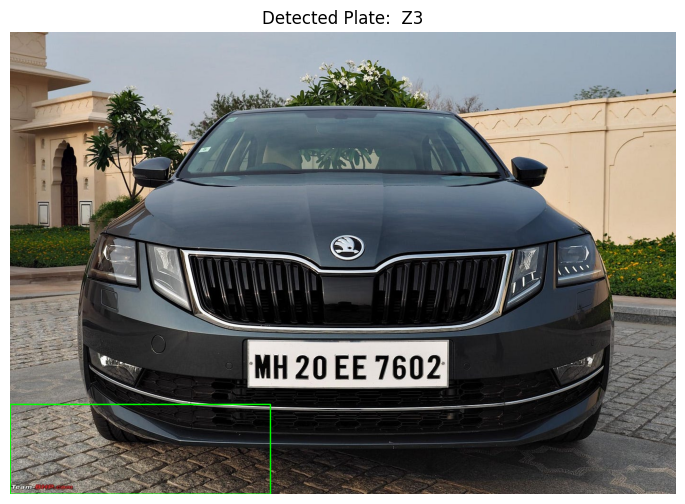

In [10]:
import cv2
import pytesseract
import numpy as np

class LicensePlateReader:
    """
    Detect and read license plates with stronger preprocessing and contour filtering.
    """

    def detect_plate(self, image_path):
        """Return (plate_region_gray, annotated_bgr)."""
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {image_path}")

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Noise reduction + edge enhancement
        blur = cv2.bilateralFilter(gray, 11, 17, 17)
        grad = cv2.Sobel(blur, ddepth=cv2.CV_8U, dx=1, dy=0, ksize=3)

        # Binary and morphology to highlight rectangular regions
        _, binary = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Find contours and filter likely plates by aspect ratio + area
        contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]

        plate_contour = None
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h
            if area < 2000 or area > img.shape[0] * img.shape[1] * 0.25:
                continue
            aspect = w / float(h)
            if 2.0 <= aspect <= 6.5:  # typical plate ratios
                # refine with polygon approximation
                peri = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
                if 4 <= len(approx) <= 8:
                    plate_contour = approx
                    break

        if plate_contour is None:
            return None, img

        x, y, w, h = cv2.boundingRect(plate_contour)
        plate_img = gray[y:y + h, x:x + w]

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        return plate_img, img

    def read_plate(self, image_path):
        plate_img, annotated = self.detect_plate(image_path)
        if plate_img is None:
            return "No plate detected", annotated

        # Improve legibility for OCR
        plate_resized = cv2.resize(plate_img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
        _, plate_bin = cv2.threshold(plate_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # OCR with whitelist and single-line mode
        config = "--psm 7 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        text = pytesseract.image_to_string(plate_bin, config=config)
        plate_text = text.strip().replace(" ", "")

        return plate_text if plate_text else "No plate detected", annotated

# Usage
reader = LicensePlateReader()
plate_number, annotated_img = reader.read_plate('/Users/karansingh/ocr-learning/pytesseract/1_qre-gAVNTuazaUPvNw2w-Q.jpg')

print(f"License Plate: {plate_number}")

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Plate:  {plate_number}')
plt.axis('off')
plt.show()

In [ ]:
import cv2
import pytesseract
import numpy as np

class LicensePlateReader: 
    """
    Detect and read license plates
    """
    
    def detect_plate(self, image_path):
        """
        Detect license plate region in image
        """
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Blur
        blurred = cv2.bilateralFilter(gray, 11, 17, 17)
        
        # Edge detection
        edged = cv2.Canny(blurred, 30, 200)
        
        # Find contours
        contours, _ = cv2.findContours(edged. copy(), cv2.RETR_TREE, 
                                        cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        
        # Find rectangular contour (license plate)
        plate_contour = None
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
            
            if len(approx) == 4:  # Rectangle
                plate_contour = approx
                break
        
        if plate_contour is None:
            return None, img
        
        # Extract plate region
        x, y, w, h = cv2.boundingRect(plate_contour)
        plate_img = gray[y:y+h, x:x+w]
        
        # Draw rectangle on original
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        return plate_img, img
    
    def read_plate(self, image_path):
        """
        Read license plate text
        """
        plate_img, annotated = self.detect_plate(image_path)
        
        if plate_img is None: 
            return "No plate detected", annotated
        
        # Preprocess plate
        _, binary = cv2.threshold(plate_img, 0, 255,
                                  cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # OCR with custom config (only alphanumeric)
        config = r'--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
        text = pytesseract.image_to_string(binary, config=config)
        
        # Clean text
        plate_text = text.strip().replace(' ', '')
        
        return plate_text, annotated

# Usage
reader = LicensePlateReader()
plate_number, annotated_img = reader.read_plate('car. jpg')

print(f"License Plate: {plate_number}")

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Plate:  {plate_number}')
plt.axis('off')
plt.show()